In [1]:
import numpy as np
import pandas as pd
#import sympy as sym
import matplotlib.pyplot as plt
from scipy import constants as const

### Wczytanie danych

In [2]:
dataR = pd.read_csv('RED.txt', delimiter=' ')
dataB = pd.read_csv('BLUE.txt', delimiter=' ')
dataY = pd.read_csv('YELLOW.txt', delimiter=' ')
dataG = pd.read_csv('GREEN.txt', delimiter=' ')

dataR.name = "RED"
dataB.name = "BLUE"
dataY.name = "YELLOW"
dataG.name = "GREEN"

datas = [dataR, dataB, dataY, dataG]
val = {}
val["RED"] = {'lamb':632e-9}
val["BLUE"] = {'lamb':465e-9}
val["YELLOW"] = {'lamb':577e-9}
val["GREEN"] = {'lamb':522e-9}


for data in datas:
    #Ustawienie rozdzielczości
    data["res_I"] = data["Zakres_I"].map({400:0.1, 4000:1, 40:0.01})
    #Zamiana z mikroV na miliV
    data.loc[data['Zakres_I'] >= 400, 'I'] /= 1000
    data.loc[data['Zakres_I'] >= 400, 'res_I'] /= 1000
    data.loc[data['Zakres_I'] >= 400, 'Zakres_I'] /= 1000

dataR.head()

,I,U,Zakres_I,res_I
0,0.0,0.04,0.4,0.0001
1,0.0,0.09,0.4,0.0001
2,0.0,0.20,0.4,0.0001
3,0.0,0.41,0.4,0.0001
4,0.0,0.59,0.4,0.0001


### Niepewności

In [3]:
Zakres_U = 20 #V
res_U = 0.01 #V
Dp_lamb = 10e-9

def calc_Dp_Multimetr_I(I, res_I):
    return I * 1.4/100 + 3 * res_I

def calc_Dp_Multimetr_U(U, res_U):
    return U * 0.3/100 + 1 * res_U

def calc_uB(Deltas):
    s = 0
    for D in Deltas:
        s += D**2 / 3
    return np.sqrt(s)

for data in datas:
    data['uI'] = data.apply(lambda row: calc_uB([ calc_Dp_Multimetr_I(row['I'], row['res_I']) ]), axis=1)
    data['uU'] = data["U"].map(lambda x: calc_uB([ calc_Dp_Multimetr_U(x, res_U) ]))
    
ulamb = calc_uB([Dp_lamb])
    

dataR.head()

,I,U,Zakres_I,res_I,uI,uU
0,0.0,0.04,0.4,0.0001,0.000173,0.005843
1,0.0,0.09,0.4,0.0001,0.000173,0.005929
2,0.0,0.20,0.4,0.0001,0.000173,0.006120
3,0.0,0.41,0.4,0.0001,0.000173,0.006484
4,0.0,0.59,0.4,0.0001,0.000173,0.006795


### Wykresy i obliczenia 

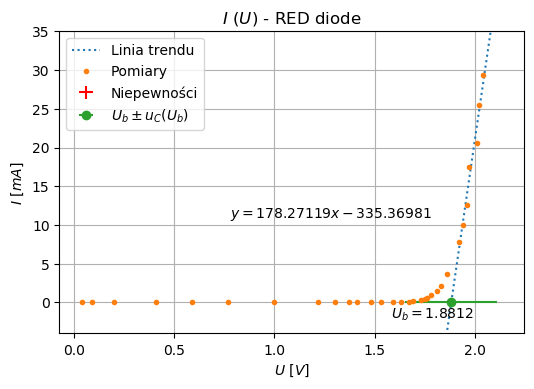

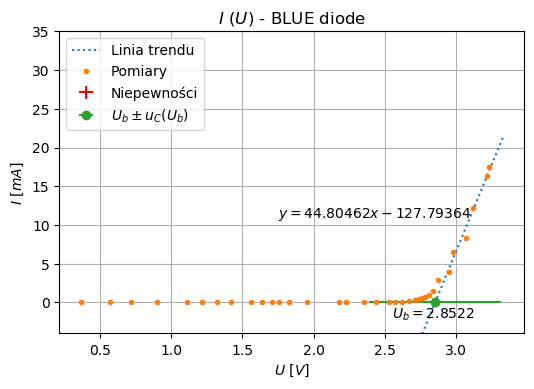

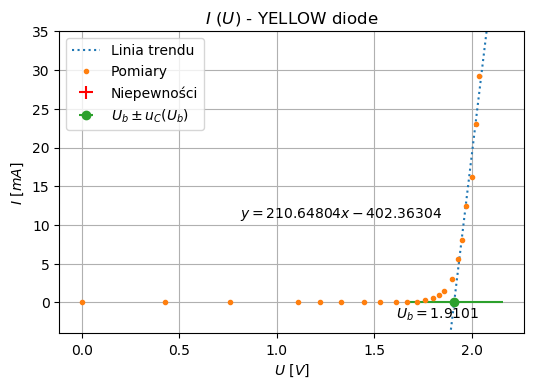

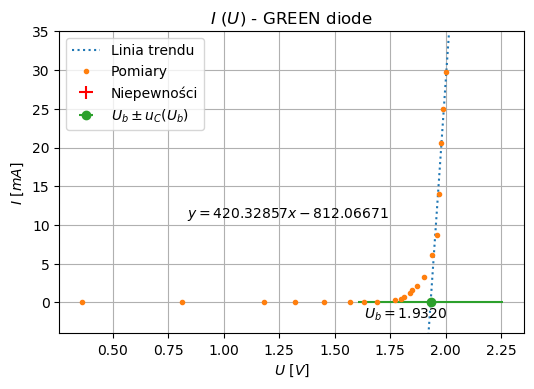

In [4]:
def my_plot(one=False):
    plt.rcParams['figure.dpi'] = 100
    for data in datas:
        x = data['U']
        y = data['I']
        xerr = data["uU"]
        yerr = data['uI']
        boundary = 5

        p, V = np.polyfit(x[y>boundary],y[y>=boundary],1, full=False, cov=True)
#         if(data.name == "YELLOW"):
#             p, V = np.polyfit(x[y>7],y[y>=7],1, full=False, cov=True)
        a = p[0]
        b = p[1]
        ua = np.sqrt(V[0][0])
        ub = np.sqrt(V[1][1])

        plt.plot(x+0.1,a*(x+0.1)+b,':',label='Linia trendu')

        plt.plot(x,y,'.',label="Pomiary")
        plt.xlabel('$U\ [V]$')
        plt.ylabel('$I\ [mA]$')
        plt.errorbar(x=x, y=y, xerr=xerr, yerr=yerr,fmt='none',color='red',label="Niepewności")

        U_b = -b/a
        dU_da = b/a**2
        dU_db = -1/a
        u_cU_b = np.sqrt(dU_da**2 * ua**2 + dU_db**2 * ub**2)

        lamb = val[data.name]['lamb']

        h = const.e / const.c * lamb * U_b
        dh_dlamb = const.e / const.c * U_b
        dh_dUb = const.e / const.c * lamb
        u_ch = np.sqrt(dh_dlamb**2 * ulamb**2 + dh_dUb**2 * u_cU_b**2)

        plt.errorbar(x=U_b, y=0, xerr=u_cU_b, label="$U_b \pm u_C(U_b)$", fmt="o")
        
        
        plt.ylim(bottom=-4, top=35)
        plt.grid(which='both',axis='both')
        if not (one):
            plt.text(U_b-1.1, 11, '$y={:.5f}x{:.5f}$'.format(a,b))
            plt.text(U_b-0.3, -2, '$U_b = {:.4f}$'.format(U_b))
            plt.legend(loc='upper left')
            plt.title("$I\ (U)$ - %s diode" % data.name)
            plt.savefig("I_U_%s.png" % data.name, dpi=600)
            plt.show()

            val[data.name].update({'a':a, 'ua':ua, 'b':b, 'ub':ub, 
                                   'U_b':U_b, 'u_cU_b':u_cU_b,
                                   'h':h, 'u_ch':u_ch})

my_plot(one=False)
#my_plot(one=True)
# print(p)
# print(np.sqrt(V[0][0]), np.sqrt(V[1][1]))

In [5]:
val

{'RED': {'lamb': 6.32e-07,
  'a': 178.2711864406767,
  'ua': 14.952169538481536,
  'b': -335.36980629539687,
  'ub': 29.61165992278987,
  'U_b': 1.8812339390975998,
  'u_cU_b': 0.22910009521870858,
  'h': 6.354034583871655e-34,
  'u_ch': 7.759799662095525e-35},
 'BLUE': {'lamb': 4.65e-07,
  'a': 44.804623753399724,
  'ua': 4.879351168008642,
  'b': -127.79364460562074,
  'ub': 15.2499825602072,
  'U_b': 2.85224233349184,
  'u_cU_b': 0.4607953048431966,
  'h': 7.088087419031107e-34,
  'u_ch': 1.1484960197636014e-34},
 'YELLOW': {'lamb': 5.77e-07,
  'a': 210.64804469273733,
  'ua': 19.21778642090266,
  'b': -402.36303538175025,
  'ub': 38.15452615098898,
  'U_b': 1.9101199632242436,
  'u_cU_b': 0.2513475660443826,
  'h': 5.890147188909445e-34,
  'u_ch': 7.773062822483582e-35},
 'GREEN': {'lamb': 5.22e-07,
  'a': 420.328571428563,
  'ua': 49.77933244600014,
  'b': -812.0667142856975,
  'ub': 98.23612096241138,
  'U_b': 1.9319807633483996,
  'u_cU_b': 0.32706686323998174,
  'h': 5.38968013

### Średnia wartość stałej Plancka

In [6]:
h_sr = 0
for color in val:
    h_sr += val[color]['h']
h_sr /= 4

u_Ah = 0
for color in val:
    u_Ah += (val[color]['h'] - h_sr)**2
u_Ah /= 4 * (4-1)
u_Ah = np.sqrt(u_Ah)

print(h_sr, u_Ah)

6.180487331938178e-34 3.609628312629519e-35


In [7]:
h_sr1 = 0
for color in val:
    if not (color == "GREEN"):
        h_sr1 += val[color]['h']
h_sr1 /= 3

u_Ah1 = 0
for color in val:
    if not (color == "GREEN"):
        u_Ah1 += (val[color]['h'] - h_sr1)**2
u_Ah1 /= 3 * (3-1)
u_Ah1 = np.sqrt(u_Ah1)

print(h_sr1, u_Ah1)

6.444089730604069e-34 3.4873468703573324e-35


### Porównanie wyników

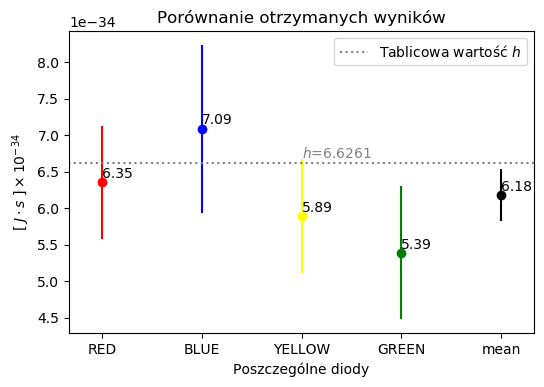

In [8]:
Plancks = {}
uPlancks = {}
for color in val:
    Plancks.update({color:val[color]['h']})
    uPlancks.update({color:val[color]['u_ch']})
Plancks['mean'] = h_sr
uPlancks['mean'] = u_Ah

names = list(Plancks.keys())
values = list(Plancks.values())
errors = list(uPlancks.values())
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["RED", "BLUE", "YELLOW", "GREEN", "BLACK","Gray"]) 
for name in names:
    #print(uPlancks[name])
    plt.errorbar(x=[name], y=[Plancks[name]], xerr=None, yerr = uPlancks[name],fmt='o')
    plt.text(name,Plancks[name]*1.01,"%.2f" % (Plancks[name] * 1e34))
#plt.errorbar(x=names,y=values,yerr=errors,fmt='o')
x = np.arange(-1,6,1)
y = np.ones(len(x))*const.h
plt.plot(x, y, ":", label="Tablicowa wartość $h$")
plt.xlim(left=-0.33, right = 4.33)
plt.text("YELLOW",const.h*1.01,"$h$=%.4f" % (const.h * 1e34),color="Gray")
plt.xlabel('Poszczególne diody')
plt.ylabel(r'$[\ J \cdot s\ ] \times 10^{-34}$')
plt.title('Porównanie otrzymanych wyników')
plt.legend()
plt.savefig("porownanie.png", dpi=600)
plt.show()

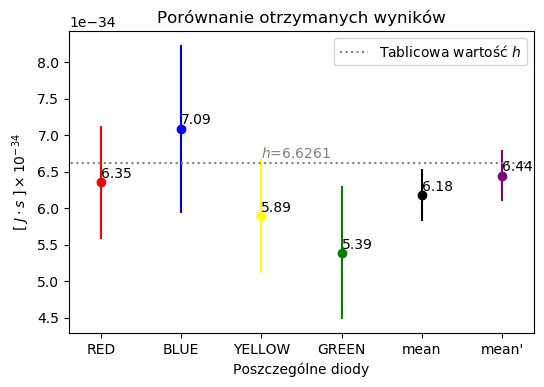

{'RED': 6.354034583871655e-34, 'BLUE': 7.088087419031107e-34, 'YELLOW': 5.890147188909445e-34, 'GREEN': 5.389680135940508e-34, 'mean': 6.180487331938178e-34, "mean'": 6.444089730604069e-34} {'RED': 7.759799662095525e-35, 'BLUE': 1.1484960197636014e-34, 'YELLOW': 7.773062822483582e-35, 'GREEN': 9.143693276746199e-35, 'mean': 3.609628312629519e-35, "mean'": 3.4873468703573324e-35}


In [9]:
Plancks = {}
uPlancks = {}
for color in val:
    Plancks.update({color:val[color]['h']})
    uPlancks.update({color:val[color]['u_ch']})
Plancks['mean'] = h_sr
uPlancks['mean'] = u_Ah
Plancks["mean'"] = h_sr1
uPlancks["mean'"] = u_Ah1

names = list(Plancks.keys())
values = list(Plancks.values())
errors = list(uPlancks.values())
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["RED", "BLUE", "YELLOW", "GREEN", "BLACK","Purple","Gray"]) 
for name in names:
    #print(uPlancks[name])
    plt.errorbar(x=[name], y=[Plancks[name]], xerr=None, yerr = uPlancks[name],fmt='o')
    plt.text(name,Plancks[name]*1.01,"%.2f" % (Plancks[name] * 1e34))
#plt.errorbar(x=names,y=values,yerr=errors,fmt='o')
x = np.arange(-1,7,1)
y = np.ones(len(x))*const.h
plt.plot(x, y, ":", label="Tablicowa wartość $h$")
plt.xlim(left=-0.4, right = 5.4)
plt.text("YELLOW",const.h*1.01,"$h$=%.4f" % (const.h * 1e34),color="Gray")
plt.xlabel('Poszczególne diody')
plt.ylabel(r'$[\ J \cdot s\ ] \times 10^{-34}$')
plt.title('Porównanie otrzymanych wyników')
plt.legend()
plt.savefig("porownanie1.png", dpi=600)
plt.show()

print(Plancks,uPlancks)

In [10]:
wynik0 = pd.DataFrame.from_dict(val, orient='columns')
wynik0.loc['lamb'] *= 1e9
wynik0.loc['h'] *= 1e34
wynik0.loc['u_ch'] *= 1e34
print(wynik0.to_latex(float_format="%.3f", bold_rows=True, escape=False, caption="Wyniki dla poszczególnych diod",
                     label="tab:wynik0"))

\begin{table}
\centering
\caption{Wyniki dla poszczególnych diod}
\label{tab:wynik0}
\begin{tabular}{lrrrr}
\toprule
{} &      RED &     BLUE &   YELLOW &    GREEN \\
\midrule
\textbf{lamb  } &  632.000 &  465.000 &  577.000 &  522.000 \\
\textbf{a     } &  178.271 &   44.805 &  210.648 &  420.329 \\
\textbf{ua    } &   14.952 &    4.879 &   19.218 &   49.779 \\
\textbf{b     } & -335.370 & -127.794 & -402.363 & -812.067 \\
\textbf{ub    } &   29.612 &   15.250 &   38.155 &   98.236 \\
\textbf{U_b   } &    1.881 &    2.852 &    1.910 &    1.932 \\
\textbf{u_cU_b} &    0.229 &    0.461 &    0.251 &    0.327 \\
\textbf{h     } &    6.354 &    7.088 &    5.890 &    5.390 \\
\textbf{u_ch  } &    0.776 &    1.148 &    0.777 &    0.914 \\
\bottomrule
\end{tabular}
\end{table}



In [11]:
data = dataR
wynik = pd.DataFrame()
wynik[[r"$I [mA]$", r"$u(I) [mA]$", r"$U [V]$", r"$u(U) [V]$", r"Zakres I $[mV]$"]] = data[["I", "uI","U","uU","Zakres_I"]].copy()
print(wynik.to_latex(escape=False, caption="Pomiary dla CZERWONEJ diody",
                     label="tab:RED", index=False, longtable=True))

\begin{longtable}{rrrrr}
\caption{Pomiary dla CZERWONEJ diody}\label{tab:RED}\\
\toprule
 $I [mA]$ &  $u(I) [mA]$ &  $U [V]$ &  $u(U) [V]$ &  Zakres I $[mV]$ \\
\midrule
\endhead
\midrule
\multicolumn{5}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
   0.0000 &     0.000173 &     0.04 &    0.005843 &              0.4 \\
   0.0000 &     0.000173 &     0.09 &    0.005929 &              0.4 \\
   0.0000 &     0.000173 &     0.20 &    0.006120 &              0.4 \\
   0.0000 &     0.000173 &     0.41 &    0.006484 &              0.4 \\
   0.0000 &     0.000173 &     0.59 &    0.006795 &              0.4 \\
   0.0000 &     0.000173 &     0.77 &    0.007107 &              0.4 \\
   0.0000 &     0.000173 &     1.00 &    0.007506 &              0.4 \\
   0.0001 &     0.000174 &     1.22 &    0.007887 &              0.4 \\
   0.0001 &     0.000174 &     1.30 &    0.008025 &              0.4 \\
   0.0003 &     0.000176 &     1.37 &    0.008146 &              0.4 \\


In [12]:
print(val["RED"]["u_ch"])
const.c
u_Ah

7.759799662095525e-35


3.609628312629519e-35

In [13]:
U_bg = val["GREEN"]["U_b"]
print(const.h * const.c / (const.e * 465e-9))

2.666326848025812


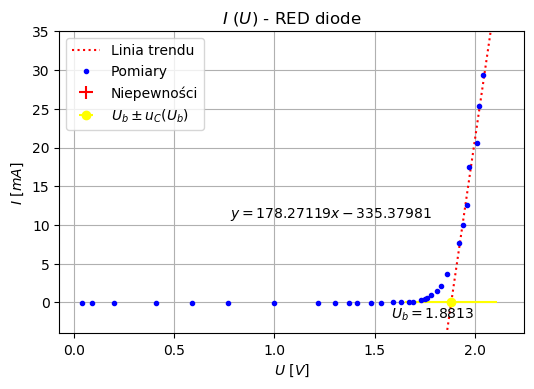

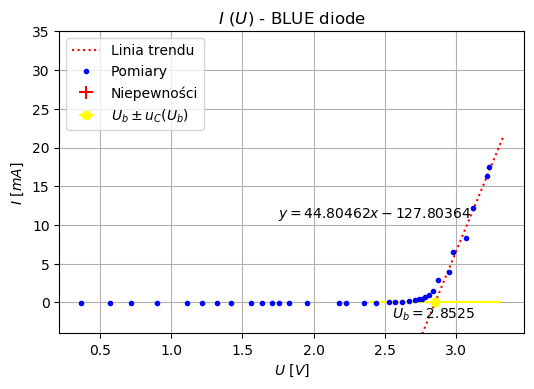

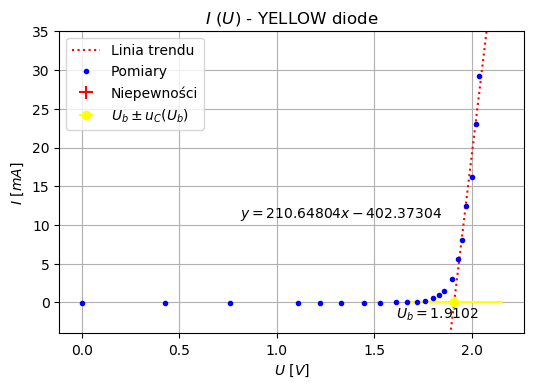

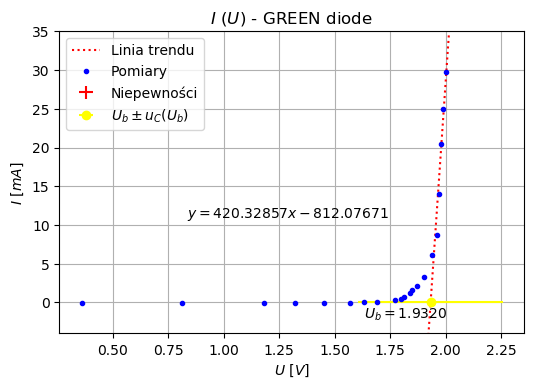

In [14]:
def my_plot(one=False):
    plt.rcParams['figure.dpi'] = 100
    for data in datas:
        x = data['U']
        y = data['I'] -0.01
        xerr = data["uU"]
        yerr = data['uI']
        boundary = 5

        p, V = np.polyfit(x[y>boundary],y[y>=boundary],1, full=False, cov=True)
#         if(data.name == "YELLOW"):
#             p, V = np.polyfit(x[y>7],y[y>=7],1, full=False, cov=True)
        a = p[0]
        b = p[1]
        ua = np.sqrt(V[0][0])
        ub = np.sqrt(V[1][1])

        plt.plot(x+0.1,a*(x+0.1)+b,':',label='Linia trendu')

        plt.plot(x,y,'.',label="Pomiary")
        plt.xlabel('$U\ [V]$')
        plt.ylabel('$I\ [mA]$')
        plt.errorbar(x=x, y=y, xerr=xerr, yerr=yerr,fmt='none',color='red',label="Niepewności")

        U_b = -b/a
        dU_da = b/a**2
        dU_db = -1/a
        u_cU_b = np.sqrt(dU_da**2 * ua**2 + dU_db**2 * ub**2)

        lamb = val[data.name]['lamb']

        h = const.e / const.c * lamb * U_b
        dh_dlamb = const.e / const.c * U_b
        dh_dUb = const.e / const.c * lamb
        u_ch = np.sqrt(dh_dlamb**2 * ulamb**2 + dh_dUb**2 * u_cU_b**2)

        plt.errorbar(x=U_b, y=0, xerr=u_cU_b, label="$U_b \pm u_C(U_b)$", fmt="o")
        
        
        plt.ylim(bottom=-4, top=35)
        plt.grid(which='both',axis='both')
        if not (one):
            plt.text(U_b-1.1, 11, '$y={:.5f}x{:.5f}$'.format(a,b))
            plt.text(U_b-0.3, -2, '$U_b = {:.4f}$'.format(U_b))
            plt.legend(loc='upper left')
            plt.title("$I\ (U)$ - %s diode" % data.name)
            plt.savefig("I_U_%s.png" % data.name, dpi=600)
            plt.show()

            val[data.name].update({'a':a, 'ua':ua, 'b':b, 'ub':ub, 
                                   'U_b':U_b, 'u_cU_b':u_cU_b,
                                   'h':h, 'u_ch':u_ch})

my_plot(one=False)
#my_plot(one=True)
# print(p)
# print(np.sqrt(V[0][0]), np.sqrt(V[1][1]))